## --- Cell 1: Import Libraries ---

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from collections import Counter

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    f1_score,
    precision_score,
    recall_score,
    brier_score_loss,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Libraries imported successfully.")

Libraries imported successfully.


## --- Cell 2: Data Loading and Splitting (Train / Valid / Test) ---
### Modification: Split data into 3 sets:
### 1. Test (20%) - final verification
### 2. Validation (20%) - intermediate check
### 3. Train (60%) - training

In [3]:
df = pd.read_csv('creditcard.csv')

X = df.drop('Class', axis=1)
y = df['Class']

### Step 1: Separate Test set (20%) and Temporary set (80%)

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

### Step 2: Split Temporary set into Training (75% of temp) and Validation (25% of temp)
### Mathematically: 0.25 * 0.8 = 0.2 (which is 20% of the total)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

print("Data split complete (Train / Valid / Test).")
print(f"Number of Train samples: {len(y_train)} ({Counter(y_train)})")
print(f"Number of Valid samples: {len(y_val)} ({Counter(y_val)})")
print(f"Number of Test samples:  {len(y_test)} ({Counter(y_test)})")

Data split complete (Train / Valid / Test).
Number of Train samples: 170883 (Counter({0: 170588, 1: 295}))
Number of Valid samples: 56962 (Counter({0: 56863, 1: 99}))
Number of Test samples:  56962 (Counter({0: 56864, 1: 98}))


## --- Cell 3: Preprocessing (Scaling) ---
### Fit scaler ONLY on Train set (not Valid, not Test)

In [6]:
scaler_amount = RobustScaler().fit(X_train[['Amount']])
X_train['scaled_amount'] = scaler_amount.transform(X_train[['Amount']])
X_val['scaled_amount'] = scaler_amount.transform(X_val[['Amount']])
X_test['scaled_amount'] = scaler_amount.transform(X_test[['Amount']])

scaler_time = RobustScaler().fit(X_train[['Time']])
X_train['scaled_time'] = scaler_time.transform(X_train[['Time']])
X_val['scaled_time'] = scaler_time.transform(X_val[['Time']])
X_test['scaled_time'] = scaler_time.transform(X_test[['Time']])

# Drop original columns
X_train = X_train.drop(['Time', 'Amount'], axis=1)
X_val = X_val.drop(['Time', 'Amount'], axis=1)
X_test = X_test.drop(['Time', 'Amount'], axis=1)

print("Data scaling complete.")

Data scaling complete.


## --- Cell 4: Model Configuration ---
### Calculate scale_pos_weight based on the new, smaller Train set

In [7]:
neg_count = Counter(y_train)[0]
pos_count = Counter(y_train)[1]
scale_pos_weight_value = neg_count / pos_count

print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

# Hyperparameters (unchanged)
best_params_xgb = {
    'subsample': 0.6,
    'reg_lambda': 1,
    'reg_alpha': 0.005,
    'n_estimators': 300,
    'min_child_weight': 1,
    'max_depth': 7,
    'learning_rate': 0.1,
    'gamma': 0.0,
    'colsample_bytree': 0.6
}

print("Optimal hyperparameters loaded.")

Calculated scale_pos_weight: 578.26
Optimal hyperparameters loaded.


## --- Cell 5: Model Training (XGBoost) ---
### Train on X_train (60% of data)

In [8]:
print("\n--- Starting model training (on Train set) ---")
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=SEED,
    n_jobs=-1,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value,
    **best_params_xgb
)

start_time = time.time()
final_model.fit(X_train, y_train)
print(f"Training complete in {time.time() - start_time:.2f}s")


--- Starting model training (on Train set) ---
Training complete in 2.24s


## --- Cell 6: Generate Predictions (Train, Valid, Test) ---

In [9]:
print("\n--- Generating predictions for Train, Valid, Test ---")

# Probabilities
y_prob_train = final_model.predict_proba(X_train)[:, 1]
y_prob_val = final_model.predict_proba(X_val)[:, 1]
y_prob_test = final_model.predict_proba(X_test)[:, 1]

FINAL_THRESHOLD = 0.6
print(f"Applied Decision Threshold: {FINAL_THRESHOLD}")

# Decisions (0 or 1)
y_pred_train = (y_prob_train > FINAL_THRESHOLD).astype(int)
y_pred_val = (y_prob_val > FINAL_THRESHOLD).astype(int)
y_pred_test = (y_prob_test > FINAL_THRESHOLD).astype(int)


--- Generating predictions for Train, Valid, Test ---
Applied Decision Threshold: 0.6


## --- Cell 7: Metric Functions ---

In [10]:
TOTAL_FRAUD_VALUE_EUR = 60000
TOTAL_FRAUD_TRANSACTIONS = 492
COST_MULTIPLIER_LOW = 3.27
EUR_TO_PLN = 4.23
AVG_FRAUD_VALUE = TOTAL_FRAUD_VALUE_EUR / TOTAL_FRAUD_TRANSACTIONS
COST_PER_FN_EUR = AVG_FRAUD_VALUE * COST_MULTIPLIER_LOW
COST_PER_FN = COST_PER_FN_EUR * EUR_TO_PLN


def calculate_ece_mce(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    ece = 0.0
    mce = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_lowers[i]) & (y_prob <= bin_uppers[i])
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            confidence_in_bin = np.mean(y_prob[in_bin])
            bin_error = np.abs(accuracy_in_bin - confidence_in_bin)
            ece += prop_in_bin * bin_error
            if bin_error > mce:
                mce = bin_error
    return ece, mce


def calculate_all_metrics(y_true, y_pred, y_prob):
    metrics = {}
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics['TP'] = tp
    metrics['FP'] = fp
    metrics['TN'] = tn
    metrics['FN'] = fn
    metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['Recall (TPR)'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['Specificity (TNR)'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['FPR'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['FNR'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    metrics['NPV'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    metrics['Error Rate'] = 1 - accuracy_score(y_true, y_pred)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Balanced Acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['F1 Score'] = f1_score(y_true, y_pred, zero_division=0)
    metrics['G-mean'] = np.sqrt(metrics['Recall (TPR)'] * metrics['Specificity (TNR)'])

    if len(np.unique(y_true)) > 1:
        metrics['AUC ROC'] = roc_auc_score(y_true, y_prob)
        pr_precision, pr_recall, _ = precision_recall_curve(y_true, y_prob)
        metrics['AUC PR'] = auc(pr_recall, pr_precision)
    else:
        metrics['AUC ROC'] = 0.5
        metrics['AUC PR'] = 0.0

    metrics['Brier Score'] = brier_score_loss(y_true, y_prob)
    metrics['Expected Cost'] = fn * COST_PER_FN
    metrics['ECE'], metrics['MCE'] = calculate_ece_mce(y_true.to_numpy(), y_prob)
    return metrics

## --- Cell 8: Calculation and Presentation of Results (3 Columns) ---

In [11]:
# Calculate metrics for all three sets
metrics_train = calculate_all_metrics(y_train, y_pred_train, y_prob_train)
metrics_val = calculate_all_metrics(y_val, y_pred_val, y_prob_val)  # New
metrics_test = calculate_all_metrics(y_test, y_pred_test, y_prob_test)


def create_summary_table_3cols(metric_list, train, val, test):
    data = {'Metric': metric_list, 'Train': [], 'Valid': [], 'Test': []}
    for metric in metric_list:
        v_train = train.get(metric)
        v_val = val.get(metric)
        v_test = test.get(metric)

        row_vals = [v_train, v_val, v_test]
        keys = ['Train', 'Valid', 'Test']

        for i, val_x in enumerate(row_vals):
            if metric == 'Expected Cost':
                data[keys[i]].append(f"{val_x:,.2f} PLN")
            else:
                data[keys[i]].append(round(val_x, 4) if isinstance(val_x, (int, float)) else val_x)

    return pd.DataFrame(data).set_index('Metric')


metrics_table_1 = [
    'TP', 'FP', 'TN', 'FN',
    'Precision', 'Recall (TPR)', 'Specificity (TNR)',
    'FPR', 'FNR', 'NPV', 'Error Rate'
]

metrics_table_2 = [
    'Accuracy', 'Balanced Acc', 'MCC', 'F1 Score', 'G-mean',
    'AUC PR', 'AUC ROC', 'Brier Score', 'ECE', 'MCE', 'Expected Cost'
]

print(f"\n{'=' * 80}")
print(f"MODEL RESULTS (Train / Valid / Test)")
print(f"{'=' * 80}")

print("\n--- Table 1: Classification Metrics ---")
print(create_summary_table_3cols(metrics_table_1, metrics_train, metrics_val, metrics_test))

print("\n--- Table 2: Quality & Calibration Metrics ---")
print(create_summary_table_3cols(metrics_table_2, metrics_train, metrics_val, metrics_test))


MODEL RESULTS (Train / Valid / Test)

--- Table 1: Classification Metrics ---
                      Train       Valid        Test
Metric                                             
TP                    295.0     76.0000     83.0000
FP                      0.0      7.0000      8.0000
TN                 170588.0  56856.0000  56856.0000
FN                      0.0     23.0000     15.0000
Precision               1.0      0.9157      0.9121
Recall (TPR)            1.0      0.7677      0.8469
Specificity (TNR)       1.0      0.9999      0.9999
FPR                     0.0      0.0001      0.0001
FNR                     0.0      0.2323      0.1531
NPV                     1.0      0.9996      0.9997
Error Rate              0.0      0.0005      0.0004

--- Table 2: Quality & Calibration Metrics ---
                  Train          Valid           Test
Metric                                               
Accuracy            1.0         0.9995         0.9996
Balanced Acc        1.0         0.8

## --- Cell 9: Confusion Matrix Visualization (For Valid and Test) ---

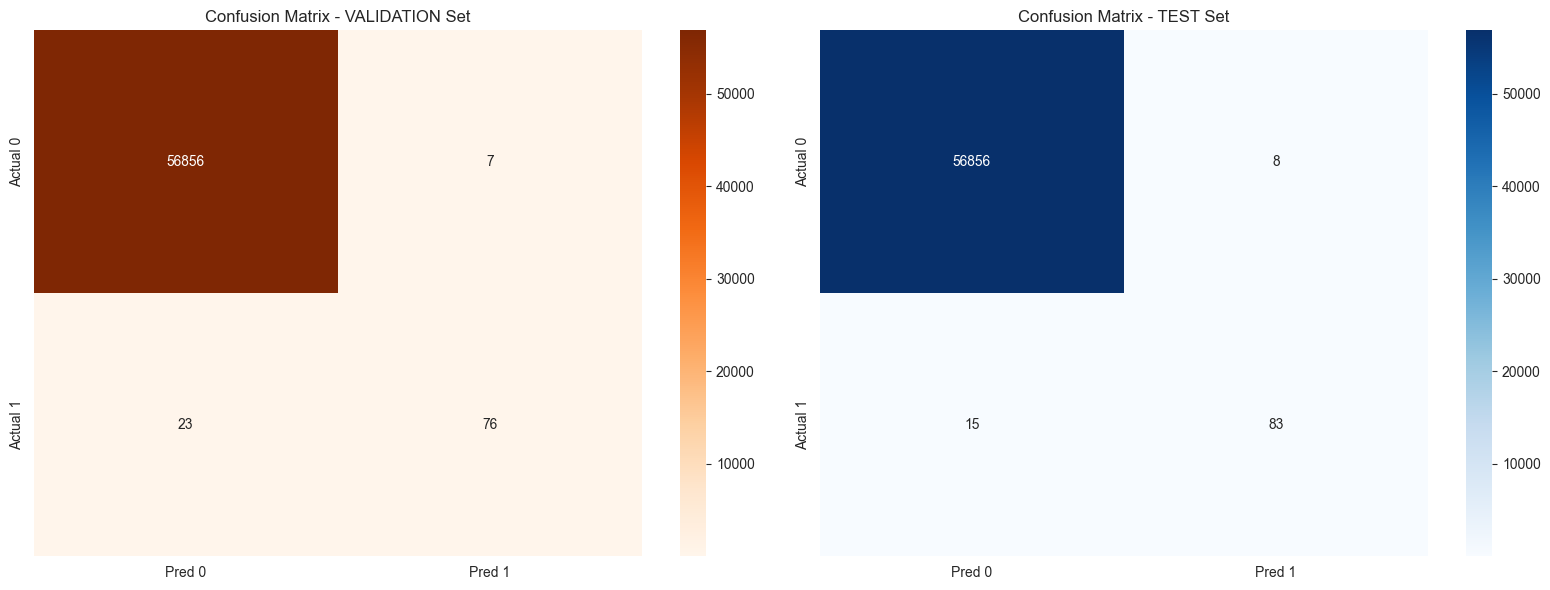

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation Matrix
cm_val = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[0].set_title(f'Confusion Matrix - VALIDATION Set')

# Test Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1].set_title(f'Confusion Matrix - TEST Set')

plt.tight_layout()
plt.savefig("matrix.png")
plt.show()